In [3]:
import yfinance as yf


In [4]:
sp500 = yf.Ticker("^GSPC")

In [5]:
sp500 = sp500.history(period="max")

In [6]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-19 00:00:00-04:00,6647.109863,6671.819824,6630.310059,6664.359863,9125960000,0.0,0.0
2025-09-22 00:00:00-04:00,6654.279785,6698.879883,6648.069824,6693.750000,5642620000,0.0,0.0
2025-09-23 00:00:00-04:00,6692.439941,6699.520020,6645.580078,6656.919922,5633620000,0.0,0.0


In [7]:
sp500.shape


(24550, 7)

In [8]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-09-12 00:00:00-04:00', '2025-09-15 00:00:00-04:00',
               '2025-09-16 00:00:00-04:00', '2025-09-17 00:00:00-04:00',
               '2025-09-18 00:00:00-04:00', '2025-09-19 00:00:00-04:00',
               '2025-09-22 00:00:00-04:00', '2025-09-23 00:00:00-04:00',
               '2025-09-24 00:00:00-04:00', '2025-09-25 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24550, freq=None)

<Axes: xlabel='Date'>

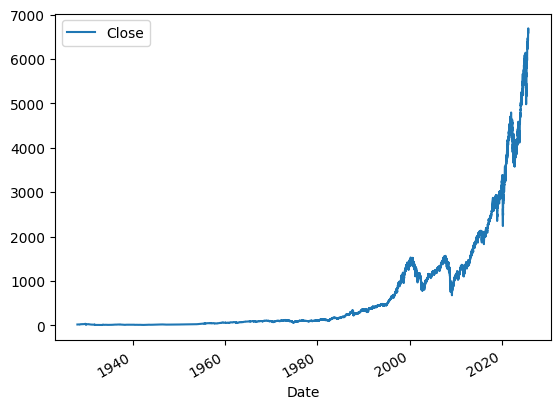

In [9]:
sp500.plot.line(y="Close",use_index= True)

In [10]:
del sp500['Dividends']
del sp500['Stock Splits']

In [11]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [12]:
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int)

In [13]:
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100,min_samples_split=100,random_state=1)
predictors = ["Open","Close","Volume","Low","High"]
train = sp500[:-100]
test= sp500[-100:]
model.fit(train[predictors],train["Target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
from sklearn.metrics import precision_score

predictions = model.predict(test[predictors])

In [16]:
import pandas as pd

In [17]:
series = pd.Series(predictions,index=test.index)

precision_score(test["Target"],series)

0.5882352941176471

<Axes: xlabel='Date'>

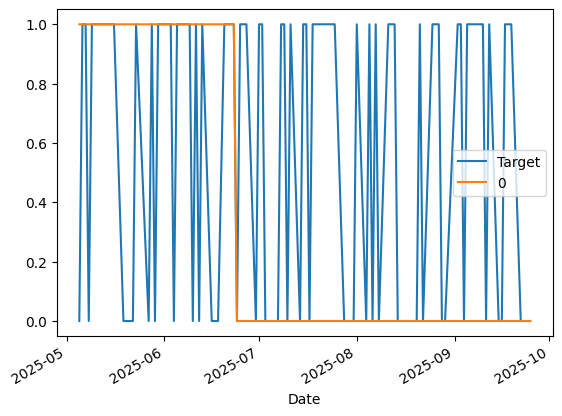

In [18]:
combined = pd.concat([test["Target"],series],axis=1)
combined.plot()

In [19]:
## Backtesting the model


In [20]:
def predict(train,test,predictors,model):
 model.fit(train[predictors],train["Target"])
 preds = model.predict(test[predictors])
 preds = pd.Series(preds,index=test.index,name="Predictions")
 combined = pd.concat([test["Target"],preds],axis=1)
 return combined   
    

In [21]:
def backtest(data,model,predictors,start=2500,step=250) :
    all_predictions=[]
    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test= data.iloc[i:(i+step)].copy()
        predictions= predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)    

In [22]:
predictions = backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()

Predictions
0    3795
1    2705
Name: count, dtype: int64

In [23]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5316081330868762

In [24]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536615
0    0.463385
Name: count, dtype: float64

In [25]:
### Adding predictors

In [26]:
horizons = [2,5,60,250,1000] # rolling averages to compare in days

In [27]:
new_predictors=[]

In [28]:
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column,trend_column]

In [30]:
sp500=sp500.dropna()

In [31]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-18 00:00:00-04:00,6626.850098,6656.799805,6611.890137,6631.959961,5292400000,6664.359863,1,1.002389,1.0,1.003667,2.0,1.039668,34.0,1.111933,141.0,1.367068,530.0
2025-09-19 00:00:00-04:00,6647.109863,6671.819824,6630.310059,6664.359863,9125960000,6693.750000,1,1.002437,2.0,1.006132,3.0,1.043187,35.0,1.116654,141.0,1.373121,530.0
2025-09-22 00:00:00-04:00,6654.279785,6698.879883,6648.069824,6693.750000,5642620000,6656.919922,0,1.002200,2.0,1.008181,3.0,1.046279,35.0,1.120833,142.0,1.378538,531.0


In [32]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=50, random_state=1)

In [33]:
def predict(train,test,predictors,model):
 model.fit(train[predictors],train["Target"])
 preds = model.predict_proba(test[predictors])[:,1]
 preds[preds >= .6] = 1
 preds[preds < .6] = 0   
 preds = pd.Series(preds,index=test.index,name="Predictions")
 combined = pd.concat([test["Target"],preds],axis=1)
 return combined 

In [34]:
predictions = backtest(sp500,model,new_predictors)

In [35]:
predictions["Predictions"].value_counts()

Predictions
0.0    4628
1.0     871
Name: count, dtype: int64

In [36]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5717566016073479

In [ ]:
### Improve the precision score even more 
### Use news data and do sentiment analysis to improve the prediction
###lets test,yes it eorks